<a href="https://colab.research.google.com/github/Hee0305/PDM06/blob/main/py-tensorflow/pdm06_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning ( 전이학습 ) 이란 

학습된 신경망의 능력을 비슷하거나 완전히 새로운 분야에 사용되는 신경망의 학습에 이용하는 것이다.

예로 들어 사람이 무언가를 배울때 그 동안에 쌓아왔던 지식을 요긴하게 다시 사용하는 것과 같다.

수업시간에 배운 대표적인 TL 모델로는 VGG19, ResNet 등을 배웠다. 

ConvNet - Convolutional Neural Network 즉 합성곱 신경망 이며, 인간의 시신경 구조를 모방한 기술이다. 
Using ConvNet
Fine tuning of ConvNet - 전이학습과 거의 유사하다. 데이터로 pretrain 된 backbone을 이용해서 특징맵을 추출하고 fine tuning을 자신의 데이터셋에 맞게 layer를 다시 설계한다. task가 바뀐 경우에도 자신의 데이터에 더욱 fit하게 학습하는것을 finetuning이라고 한다. 

전이학습은 데이터가 수가 적어도 효과적일수 있고, 학습속도도 빠른편이다. 
또한 전이학습을 거치는것이 그렇지 않은것 보다 높은 정확도를 얻을 수 있다.

================================================================================

cifar10 에 대한 TL 결과 요약 

모델에 대한 학습 시간이 상당히 길었다. 
이미지 리사이징( 이미지 크기 변환) 부터 새로 시도해보았으며 
간단하게는 batch size = 16,32,64 로 변환, learning late = 0.001,0.0001,0.0005 등 변환해보았다, 

augmentation 에서는 shear_range , brightness_range 등 여러가지 파라미터 값들을 바꿨다. 
정확도가 그다지 높게 나오지 않아 모델 레이어 같은 경우도 처음부터 다시짜봤는데 dense의 수를 늘리고 batchnomalization 을 줄이고 dropout 을 사용했다. dropout같은 경우에도 (0.5) 를 계속사용하는 방법은 무리라고 생각해서 (0.3)(0.2)등으로 바꿔서 진행하였으며, Flatten layer 위에 golbalaveragepooling 과 maxpooling을 번갈아 가며 넣어보고 batchnomalization을 진행하였다. 

결과적으로 maxplling보다 globalaveragepooling이 조금더 높게 나왔으며, 

학습하는데에 있어서 콜백에 기준을 val_accuracy를 val_loss로 바꿔서 진행해 보았고 그 과정에서 mode='max' 에서 mode='min'으로 진행하였다. 
patience 같은 경우에도 5로 지정되어있는것을 10 으로 늘려서 조금더 학습량을 늘렸다. 

추가적으로 ko = tf.keras.optimizers.SGD ) 옵티마이저에서 Adam 에서 SGD로 바꾸었을때 결과가 조금더 잘나왔다 .

결과적으로 layer에서 많은 수정을 거치는 바람에 살짝 오버피팅이 되는것을 체감하였지만 정확도는 85.61로 높게 나왔음을 확인하였다. 
 

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


**Load Data and train data split**

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10

x_train,_ = train_test_split(x_train,test_size=0.9,random_state=304,shuffle=True)
y_train,_ = train_test_split(y_train,test_size=0.9,random_state=304,shuffle=True)

print(x_train.shape)
print(y_train.shape)


y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


(5000, 32, 32, 3)
(5000, 1)


**Data augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
batch_size = 16 # 16,32,64 change
datagen = ImageDataGenerator(rescale=1./255.,                          
                             rotation_range=15, # 이미지 회전값
                             # shear_range=0.5, # 이미지 기울기
                             width_shift_range=0.1, # 좌우이동
                             height_shift_range=0.1, # 상하이동
                             horizontal_flip=True
                             # brightness_range=[0.9,1.1], # 밝기
                             # zoom_range=[0.1,0.1] # 확대 
                             )
datagen.fit(x_train)

datagen2 = ImageDataGenerator(rescale=1./255.,)

valid_generator = datagen2.flow(x_test,
                               y_test,
                               batch_size=batch_size,
                               )


generate_img_num = 2
generated_data = []
generated_data_label = []
for index in range(len(x_train)):
  count = 0
  x = x_train[index].reshape((1,) + x_train[index].shape)
  for batch in datagen.flow(x, batch_size=1):
    count += 1
    generated_data.append(batch)
    generated_data_label.append(y_train[index])
    if count == generate_img_num: 
        break

x_train = np.squeeze(np.array(generated_data))

y_train = np.array(generated_data_label)



In [ ]:
# print(len(train_generator))
print(len(valid_generator))

625


In [ ]:
# print(train_generator.n)
print(valid_generator.n)

10000


**Model ( MobileNetV2 )**

In [ ]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
len(TL_base.layers)

154

In [ ]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

**Model**

In [ ]:
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [ ]:
TL_base = models.Model(TL_base.input, TL_base.layers[-4].output)
TL_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
ko = tf.keras.optimizers.SGD(lr=0.0001,momentum=0.9) # Adam -> SGD 변경 / lr= 0.001, 0.0001

input_tensor = layers.Input(shape=(32,32,3))
#이미지 리사이즈
up1 = tf.image.resize(input_tensor,(224,224))

#skip connection 
ori_img = tf.image.resize(input_tensor,(7,7))

#pretrain모델 불러오기
base_mob = TL_base(up1)


def conv_model2(base_mob,ori_img):
  act0 = tf.nn.relu(base_mob)
  conv1 = layers.Conv2D(10, 7, padding='same')(act0) # Conv2D
  BN1 = layers.BatchNormalization()(conv1)
  act1 = tf.nn.relu(BN1)

  concat = layers.concatenate([ori_img, act1], axis=3)
  average_pool = layers.GlobalAveragePooling2D()(concat)

  TL_1 = layers.Flatten()(average_pool)
  TL_2 = layers.Dense(2048,activation='relu')(TL_1)
  #a1 = layers.BatchNormalization()(TL_2)
  a2 = layers.Dropout(0.3)(TL_2)
  TL_3 = layers.Dense(1024,activation='relu')(a2)
  #a3 = layers.BatchNormalization()(TL_3)
  a3 = layers.Dropout(0.3)(TL_3)
  TL_4 = layers.Dense(512,activation='relu')(a3)
  #a4 = layers.BatchNormalization()(TL_4)
  a4 = layers.Dropout(0.2)(TL_4)
  TL_5 = layers.Dense(256,activation='relu')(a4)
  #a5 = layers.BatchNormalization()(TL_5)
  a5 = layers.Dropout(0.2)(TL_5)
  TL_6 = layers.Dense(128,activation='relu')(a5)
  #a5 = layers.BatchNormalization()(TL_6)
  TL_7 = layers.Dense(64,activation='relu')(TL_6) 

  output_tensor = layers.Dense(10,activation='softmax')(TL_7)


  return output_tensor



def dense_model(base_mob):

  TL_0 = layers.GlobalAveragePooling2D()(base_mob)
  TL_1 = layers.Flatten()(TL_0)
  
  TL_2 = layers.Dense(4096,activation='relu')(TL_1)
  drop1 = layers.Dropout(0.3)(TL_2)
  TL_3 = layers.Dense(2048,activation='relu')(TL_1)
  drop2 = layers.Dropout(0.3)(TL_3)
  TL_4 = layers.Dense(1024,activation='relu')(drop2)
  drop3 = layers.Dropout(0.2)(TL_4)  
  TL_5 = layers.Dense(512,activation='relu')(drop3)
  drop4 = layers.Dropout(0.2)(TL_5)  
  TL_6 = layers.Dense(256,activation='relu')(drop4)
  drop5 = layers.Dropout(0.2)(TL_6)
  TL_7 = layers.Dense(128,activation='relu')(drop5)
  output_tensor = layers.Dense(10,activation='softmax')(TL_7)

  return output_tensor

#best
output_tensor = conv_model2(base_mob,ori_img)
#output_tensor = dense_model(base_mob)
model = models.Model(input_tensor, output_tensor)


#averagepooling -> maxpooling
# dropout(0.5) -> (0.3) or (0.2) change




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 320)    1843264     ['tf.image.resize[0][0]']        
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 7, 7, 320)    0           ['model[0][0]']                  
                                                                                            

**Network architecture**

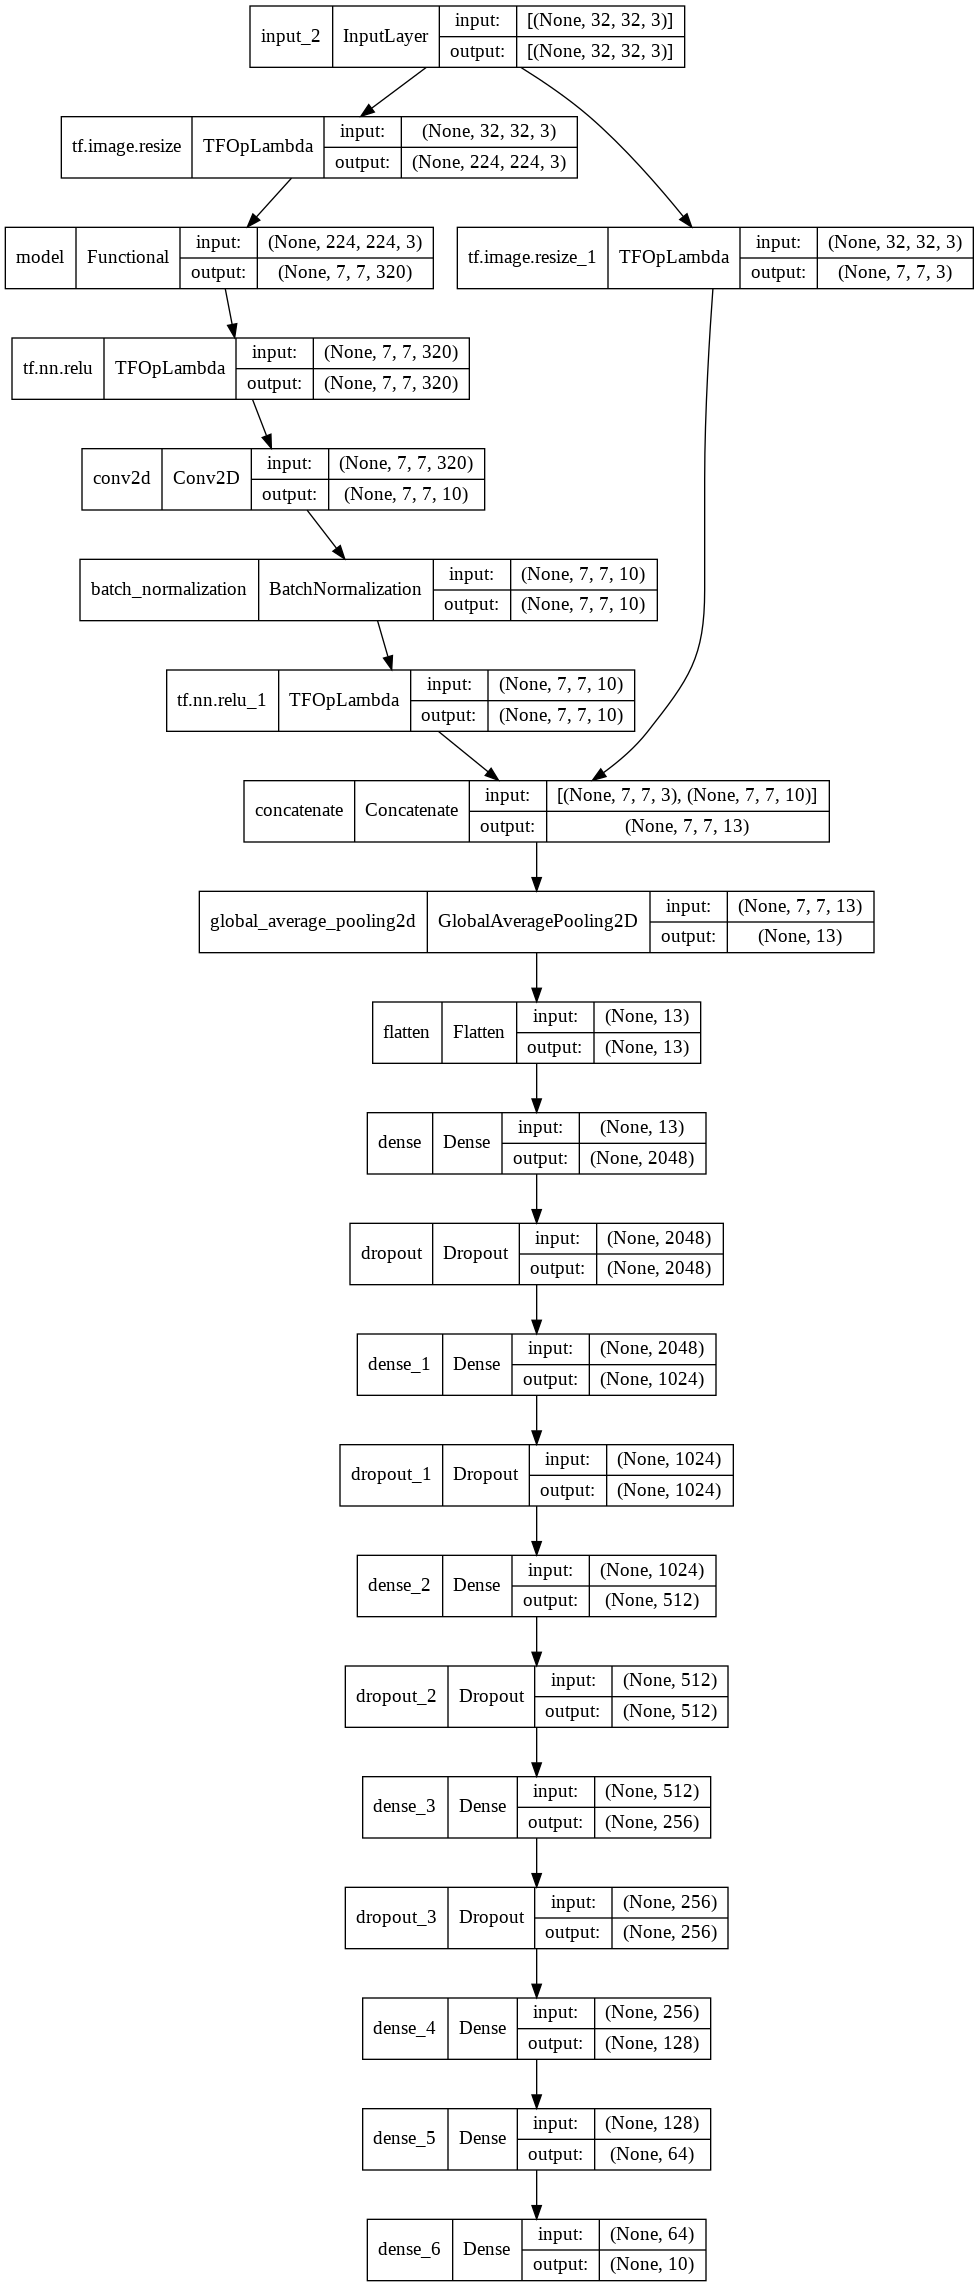

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [ ]:
from tensorflow.keras import layers, models, callbacks

**callback and best model save**

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./best_model.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True) # val_accuracy -> val_loss
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', # val_accuracy -> val_loss
                            mode='max', verbose=1, patience=10) # mode=max -> mode=min
model.compile(optimizer = ko , loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=x_train.shape[0]//batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(x=x_train,y=y_train,
                    batch_size = batch_size,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,callbacks=[mc_callback,es_callback])


Epoch 1/1000
624/625 [============================>.] - ETA: 0s - loss: 2.3031 - accuracy: 0.0978

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 59s 89ms/step - loss: 2.3031 - accuracy: 0.0977 - val_loss: 2.3015 - val_accuracy: 0.1015
Epoch 2/1000
625/625 [==============================] - 55s 87ms/step - loss: 2.3019 - accuracy: 0.0983 - val_loss: 2.3003 - val_accuracy: 0.1078
Epoch 3/1000
625/625 [==============================] - 55s 88ms/step - loss: 2.3009 - accuracy: 0.1103 - val_loss: 2.2987 - val_accuracy: 0.1191
Epoch 4/1000
625/625 [==============================] - 55s 87ms/step - loss: 2.2996 - accuracy: 0.1162 - val_loss: 2.2966 - val_accuracy: 0.1303
Epoch 5/1000
625/625 [==============================] - 54s 87ms/step - loss: 2.2985 - accuracy: 0.1230 - val_loss: 2.2936 - val_accuracy: 0.1410
Epoch 6/1000
625/625 [==============================] - 54s 87ms/step - loss: 2.2961 - accuracy: 0.1402 - val_loss: 2.2888 - val_accuracy: 0.1525
Epoch 7/1000
625/625 [==============================] - 54s 87ms/step - loss: 2.2929 - accuracy: 0.1493 - val_loss: 2.2813 - val_accuracy

In [ ]:
#best model load
myModel = load_model("./best_model.hdf5")
# myModel.summary()
#predict
y_pred = myModel.predict(x_test/255.)



**Fine tuning**

In [ ]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  151


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile model
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

**Train fine-tuned model**

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./best_model.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True) # val_accuracy -> val_loss
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', # val_accuracy -> val_loss
                            mode='max', verbose=1, patience=10) # val_loss 사용시 mode='min' 으로 


In [ ]:
history_dict = history.history
loss = history_dict['loss']

INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS 

In [ ]:
%%time
history = model.fit(x=x_train,y=y_train,
                    batch_size = batch_size,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,callbacks=[mc_callback,es_callback])

Epoch 1/1000
625/625 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.6840

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 70s 106ms/step - loss: 0.9449 - accuracy: 0.6840 - val_loss: 1.5999 - val_accuracy: 0.5211
Epoch 2/1000
625/625 [==============================] - 66s 105ms/step - loss: 0.5632 - accuracy: 0.8121 - val_loss: 1.5207 - val_accuracy: 0.5984
Epoch 3/1000
625/625 [==============================] - 66s 105ms/step - loss: 0.4219 - accuracy: 0.8618 - val_loss: 1.1382 - val_accuracy: 0.7095
Epoch 4/1000
625/625 [==============================] - 65s 105ms/step - loss: 0.3133 - accuracy: 0.9000 - val_loss: 1.0299 - val_accuracy: 0.7413
Epoch 5/1000
625/625 [==============================] - 66s 105ms/step - loss: 0.2307 - accuracy: 0.9250 - val_loss: 0.9176 - val_accuracy: 0.7679
Epoch 6/1000
625/625 [==============================] - 65s 105ms/step - loss: 0.2172 - accuracy: 0.9294 - val_loss: 0.8771 - val_accuracy: 0.7953
Epoch 7/1000
625/625 [==============================] - 65s 104ms/step - loss: 0.1819 - accuracy: 0.9416 - val_loss: 1.0066 - val_a

**Best accuracy : 0.8561**

In [ ]:
from keras.models import load_model

model_best = load_model("./best_model.hdf5")
model_best.evaluate(valid_generator, batch_size=batch_size)

625/625 [==============================] - 29s 45ms/step - loss: 0.7426 - accuracy: 0.8561


[0.7425916790962219, 0.8561000227928162]

**confusion Maxtrix**

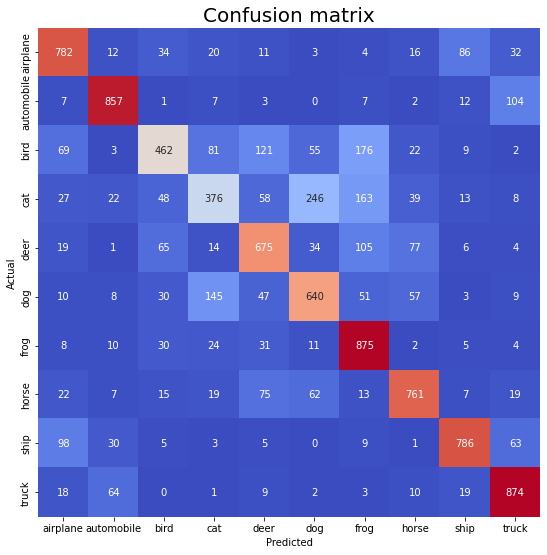

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y_pred,axis = 1))

import seaborn as sns
plt.figure(figsize=(9,9))
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(CM, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()